# Smoothing heterogeneity: the monitoring case

Revisiting here the <a href="../g5k/02_observability.ipynb">"observability notebook"</a> in the context of mixed G5K/FIT resources.

---

- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib
- Source code: https://gitlab.inria.fr/discovery/enoslib
---


## Prerequisites

<div class="alert alert-block alert-warning">
    Make sure you've run the one time setup for your environment (e.g one time setup for https://labs.iot-lab.info)
</div>



## Monitoring options

Experimenters rely on monitoring to get insight on their deployments.
Fit and G5k provide their own job monitoring infrastructure. An thus an experimenter have different choices:
- Get metrics from the infrastructure (G5K REST API / FIT oml files). This is especially interesting for environnemental metrics (power ...)
- Deploy their own monitoring tool




### On Grid'5000

There are also different options to interact with the REST API (see https://www.grid5000.fr/w/Grid5000:Software#Experiment_management_tools) and of course `curl`. REST API specification is available here: https://api.grid5000.fr/doc/3.0/


From python you can use [`python-grid5000`](https://pypi.org/project/python-grid5000/).

In [ ]:
from grid5000 import Grid5000
from pathlib import Path

conf = Path.home() / ".python-grid5000.yaml"

gk = Grid5000.from_yaml(conf)

In [ ]:
# get the list of the available metrics for a given cluster
import json

metrics = gk.sites["lyon"].clusters["nova"].metrics
print(json.dumps(metrics, indent=4))

In [ ]:
[m["name"] for m in metrics]

In [ ]:
import time
metric = "wattmetre_power_watt"
now = time.time()
measurements = gk.sites["lyon"].metrics.list(nodes="nova-1,nova-2,nova-3", start_time=now - 1000, metrics=metric)

# alternatively one can pass a job_id
# measurements = gk.sites["lyon"].metrics.list(job_id=1307628, metrics=metric)
measurements[:10]

In [ ]:
import pandas as pd

df = pd.DataFrame([m.to_dict() for m in measurements])
df["timestamp"] = pd.to_datetime(df["timestamp"])
import seaborn as sns

sns.relplot(data=df, x="timestamp", y="value", hue="device_id", alpha=0.7)

### On IOT-LAB

One need to attach a `profile` to the experiment (either at reservation time or dynamically)

In [ ]:
!ls tutorial_m3.elf || wget -q https://raw.githubusercontent.com/wiki/iot-lab/iot-lab/firmwares/tutorial_m3.elf

In [ ]:
import enoslib as en
from enoslib.infra.enos_iotlab.configuration import ConsumptionConfiguration

en.init_logging()

FIT_SITE="grenoble"

fit_conf = (
    en.IotlabConf.from_settings(job_name="tutorial_m3", walltime="02:00")
    .add_machine(roles=["xp_fit"], archi="m3:at86rf231", site=FIT_SITE, number=1, image="tutorial_m3.elf", profile="test_profile")
    .add_profile(name="test_profile", archi="m3", consumption=ConsumptionConfiguration(current=True, power=True, voltage=True, period=8244, average=4))
)
fit_conf

fit = en.Iotlab(fit_conf)
fit_roles, _ = fit.init()


In [ ]:
# wait a bit for data to be collected and flushed
import time
time.sleep(20)


In [ ]:
fit.collect_data_experiment()

In [ ]:
import tarfile
job_id = fit.client.get_job_id()
tar = tarfile.open("%s.tar.gz" % (job_id)) # tar = tarfile.open("%s-%s.iot-lab.info.tar.gz" % (job_id, FIT_SITE))
tar.extractall(path=".")
tar.close()

In [ ]:
%matplotlib widget
from oml_plot_tools import consum

from pathlib import Path
# iterate over all the *.om found
consuption_dir = Path(str(job_id)) / "consumption"
for consumption in consuption_dir.glob("*.oml"):
  print(consumption)
  data = consum.oml_load(consumption)
  data = data[0:1000]
  consum.consumption_plot(data, 'consumption', ('power'))

In [ ]:
fit.destroy()

## User defined monitoring


The user deploys its own monitoring solution
EnOSlib provides different ways of doing that:
- a lightweight monitoring: based on independant monitoring processes running on each host
- an heavyweight monitoring: based on a classical monitoring stack (Telegraf + InfluxBD/Prometheus + Grafana)

Monitoring stacks are exposed using EnOSlib's `Service`. We show that these service can mix G5K + FIT nodes.

We reserve:
- 2 nodes on G5K
- 1 A8 nodes on FIT

In [ ]:
import enoslib as en

en.init_logging()

network = en.G5kNetworkConf(type="prod", roles=["my_network"], site="rennes")

g5k_conf = (
    en.G5kConf.from_settings(job_type=[], job_name="fit_g5k_monitoring")
    .add_network_conf(network)
    .add_machine(
        roles=["xp", "collector"], cluster="paravance", nodes=1, primary_network=network
    )
    .add_machine(
        roles=["xp", "agent"], cluster="paravance", nodes=1, primary_network=network
    )
    .finalize()
)
g5k_conf

In [ ]:
FIT_SITE="grenoble"

fit_conf = (
    en.IotlabConf.from_settings(job_name="riot_a8", walltime="02:00")
    .add_machine(roles=["agent"], archi="a8:at86rf231", site=FIT_SITE, number=1)
)
fit_conf

In [ ]:
# Here we set up a special provider that will try to reserve both G5k and Iotlab configuration simultaneously

from enoslib.infra.providers import Providers

iotlab_provider = en.Iotlab(fit_conf, name="Iotlab")
g5k_provider = en.G5k(g5k_conf, name="G5k")

providers = Providers([iotlab_provider,g5k_provider])

roles, networks = providers.init(86400)
iotlab_provider, g5k_provider = providers.providers

### Lightweight monitoring
EnOSlib has a lighweight monitoring service based on Dstat.

```
Dstat service anatomy:
----------------------
.deploy: deploys a monitoring process in the background on each targetted nodes and store metric in a file
.destroy: stop the monitoring process on each node
.backup: retrieve all the monitoring files back to your control node for post-mortem analysis
```

In [ ]:
# a context manager that do deploy when entering and destroy + backup when exiting
with en.Dstat(nodes=roles["agent"]) as d:
    import time
    time.sleep(5)
    en.run_command("apt install -y stress && stress --timeout 10 --cpu 8", roles=roles["G5k"] & roles["agent"])
    time.sleep(5)

In [ ]:
import seaborn as sns

sns.relplot(data=en.Dstat.to_pandas(d.backup_dir), x="epoch", y="idl", hue="host")

### Heavyweight monitoring stack

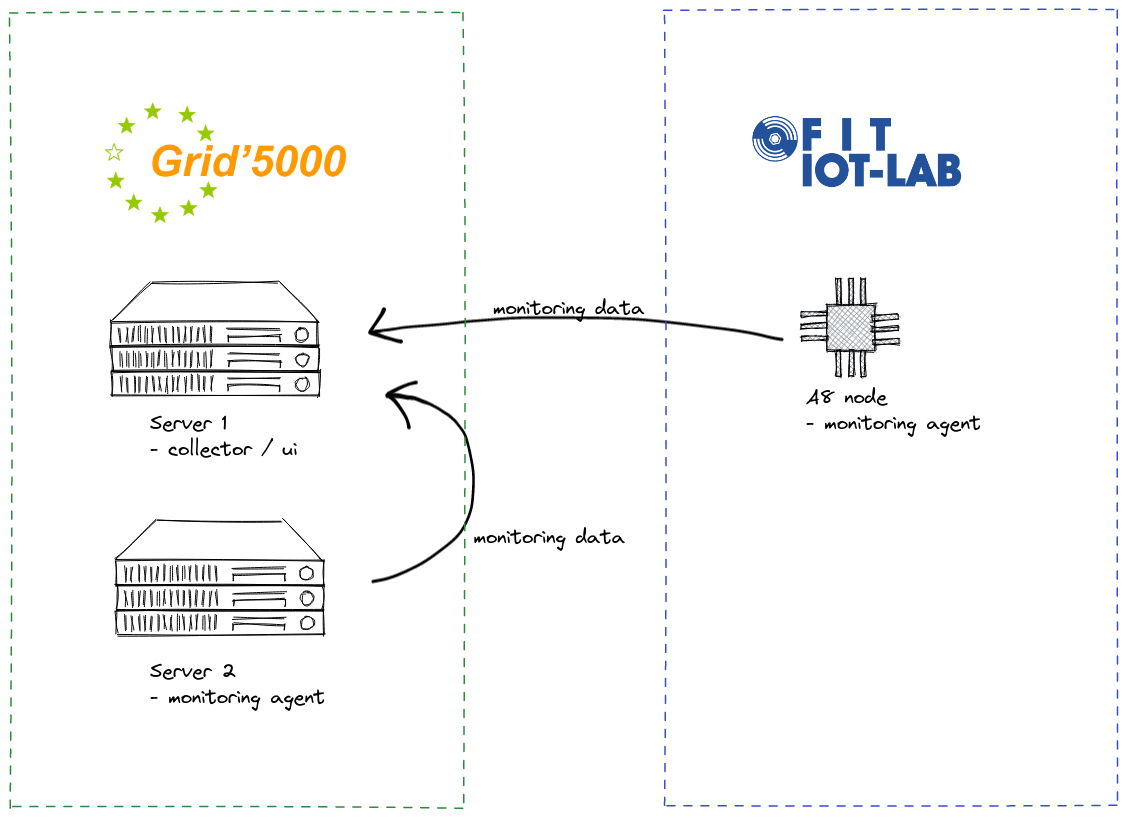


In [ ]:
en.run_command("dhclient -6 br0", roles=roles["G5k"])

# mandatory for the following
roles = en.sync_info(roles,networks)

A good practice to deploy docker on G5k is to the EnOSlib service to
- install docker agent on all nodes
- configure the deamon to use the Grid'5000 registry cache
- bind the docker state directory to a place with some space

In [ ]:
docker = en.Docker(agent=roles["xp"],
                 bind_var_docker="/tmp/docker",
                 registry_opts=dict(type="external", ip="docker-cache.grid5000.fr", port=80))
docker.deploy()

We're now ready to instantiate the Monitoring Service,

We only need to make sure to bind the various client on the IPv6 networks and make the client use these networks.

In [ ]:
def get_nets(networks, net_type):
    """ Aux method to filter networks from roles """
    return set([
        n for net_list in networks.values() for n in net_list
        if isinstance(n.network, net_type)
    ])

In [ ]:
from ipaddress import IPv6Network
get_nets(networks, IPv6Network)

In [ ]:
m = en.TIGMonitoring(
    # collector is the node where the DB will be deployed and
    # where the monitoring data will be sent
    collector=roles["collector"][0],
    # agent are the nodes where the monitoring agent will be deployed
    # on g5k we deploy those using docker
    # while on fit we deploy the agent from the binary
    agent=roles["agent"],
    # ui is the node where the dashboard will be deployed
    ui=roles["collector"][0],
    # networks represent the network to use (agent <-> collector communication)
    networks=get_nets(networks, IPv6Network)
)
m.deploy()


In [ ]:
print(f"""
Access the UI at {m.ui.address}:3000 (admin/admin)")
---
tip1: create a ssh port forwarding -> ssh -NL 3000:{m.ui.address}:3000 access.grid5000.fr (and point your browser to http://localhost:3000)
tip2: use a proxy socks -> ssh -ND 2100 access.grid5000.fr (and point your browser to http://{m.ui.address}:3000)
tip3: use the G5K vpn
""")

In [ ]:
g5k_provider.fw_create(proto="tcp+udp", port=8086)

In [ ]:
proc = (roles["G5k"] & roles["agent"])[0].processor
cpu_stress = proc.cores * proc.count

en.run_command(f"stress --cpu {cpu_stress} --timeout 30", roles=[host for host in roles["G5k"] if host in roles["agent"]])

This is an example of the outcome in the dashboard

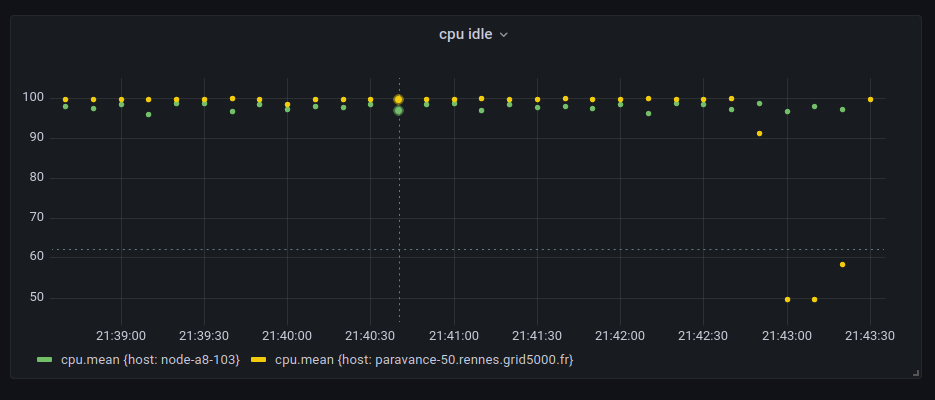

## Clean up

In [ ]:
providers.destroy()